Consider the process
$$\psi_i(X)=e^{-t_i}|X|,\quad t_i=\{0,1,2,\ldots, N\}$$
with $X\approx\mathcal{N}(0,1)$.

Compute
$$A = \mathbb{E}\left[\max\left(\sum_{k=1}^N \psi_k(X) - K, 0\right)\right]$$
both directly using Monte Carlo simulation and by using Jamshidian's decomposition.

Plot the results against the strike $K$.

In [2]:
import numpy as np

def psi(t_i, X):
    return np.exp(-t_i*np.abs(X))

def sumPsi(N, X, psi):
    A = 0
    for t_i in range(0, N):
        A += psi(t_i, X)
    return A

np.random.seed(1)
nsimulations = 1000
N = 15
X = np.random.normal(size=nsimulations)

K = np.linspace(2, 10, 100)
resultMC = np.zeros(len(K))
sum_of_functions = sumPsi(N, X, psi)
for i, Ki in enumerate(K):
    resultMC[i] = np.mean(np.maximum(sum_of_functions - Ki, 0))

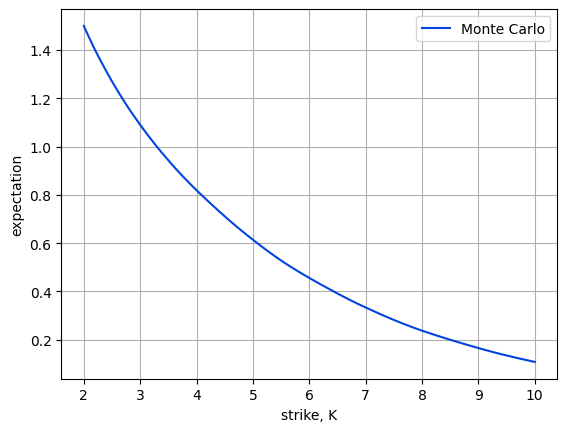

In [ ]:
import matplotlib.pyplot as plt

plt.plot(K, resultMC, color="xkcd:blue")
plt.grid(True)
plt.xlabel('strike (K)')
plt.ylabel('expectation')
plt.legend(['Monte Carlo'])
plt.show()

The $\psi_i$ are monotic decreasing so we can apply Jamshidian decomposition

$$A = \mathbb{E}\left[\sum_{i=1}^N \max(\psi_i(X) - \psi_i(X^*), 0)\right]$$

with $\sum_{i=1}^N \psi_i(X^*) = K$

In [5]:
import numpy as np

from scipy.optimize import newton

def objective(x, psi, N, K):
    temp = 0
    for i in range(0, N):
        temp += psi(i, x)
    return temp - K

def jamshidian_decomposition(psi, N, K):
    result = newton(objective, 0.1, args=(psi, N, K))
    return result

np.random.seed(1)
nsimulations = 1000
N = 15
X = np.random.normal(size=nsimulations)

K = np.linspace(2, 10, 100)
resultJams = np.zeros(len(K))
for i, Ki in enumerate(K):
    optK = jamshidian_decomposition(psi, N, Ki)
    A = 0
    for j in range(0, N):
        A += np.mean(np.maximum(psi(j, X) - psi(j, optK), 0))
    resultJams[i] = A

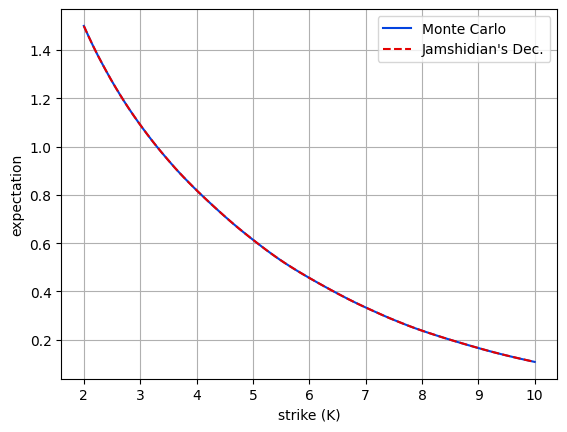

In [6]:
plt.plot(K, resultMC, color="xkcd:blue")
plt.plot(K,resultJams, linestyle='--', color="xkcd:red")
plt.grid(True)
plt.xlabel('strike (K)')
plt.ylabel('expectation')
plt.legend(['Monte Carlo',"Jamshidian's Dec."])
plt.show()

Implement the Jamshidian decomposition to price swaptions under the Vasicek short rate model

$$dr = k(\theta - r_t)dt + \sigma dW$$

(all the Vasicek related formulas implemented below can be found in Brigo-Mercurio)

In [7]:
import numpy as np

from enum import IntEnum
from scipy.stats import norm

class Vasicek:
  def __init__(self, theta, k, sigma):
    self.theta = theta
    self.k = k
    self.sigma = sigma

  def B(self, t, T):
    return 1/self.k*(1-np.exp(-self.k*(T-t)))

  def A(self, t, T):
    return np.exp((self.theta-self.sigma**2/(2*self.k**2))*(self.B(t, T)-T+t)-self.sigma**2/(4*self.k)*self.B(t, T)**2)

  def ZCB(self, r, t, T):
    return self.A(t, T)*np.exp(-self.B(t, T)*r)

  def ZBO(self, r, K, t, T, S, option_type=1):
    sigma_p = self.sigma*np.sqrt((1-np.exp(-2*self.k*(T-t)))/(2*self.k))*self.B(T, S)
    h = 1/sigma_p*np.log((self.ZCB(r, t, S))/(self.ZCB(r, t, T)*K))+sigma_p/2
    arg1 = option_type*h
    arg2 = option_type*(h-sigma_p)
    return option_type*(self.ZCB(r, t, S)*norm.cdf(arg1)-K*self.ZCB(r, t, T)*norm.cdf(arg2))

\begin{equation*}
\textbf{PSw}=NP(t_0, T_\alpha)\mathbb{E}_t\left[\max\left(1-\sum_{k=\alpha+1}^\beta c_kP(T_\alpha,T_k), 0\right)\right]
\end{equation*}
with $c_k=K\tau_k$ for $k=\alpha+1,\ldots,\beta-1$ and $c_\beta=(1+K\tau_\beta)$.

\begin{equation*}
P(t,T) = A_r(t,T)e^{-B_r(t,T)r}
\end{equation*}

Hence
\begin{equation*}
\textbf{PSw}=NP(t_0, T_\alpha)\mathbb{E}_t\left[\max\left(1-\sum_{k=\alpha+1}^\beta c_k A_r(\tau_k)e^{-B_r(\tau_k)r(T_\alpha)}, 0\right)\right]
\end{equation*}

Using the Jamshidian decomposition:
\begin{equation*}
\textbf{PSw}=NP(t_0, T_\alpha)\sum_{k=\alpha+1}^\beta c_k \mathbb{E}_t\left[\max\left(\bar{K_k} - A_r(\tau_k)e^{-B_r(\tau_k)r(T_\alpha)}, 0\right)\right]
\end{equation*}
whit $\bar{K_k} := A_r(\tau_k)e^{-B_r(\tau_k)r^{*}}$, where the parameter $r^{*}$ is determined by solving
\begin{equation*}
\sum_{k=\alpha+1}^\beta c_k \left(A_r(\tau_k)e^{-B_r(\tau_k)r^{*}}\right) = 1
\end{equation*}

Each element of the sum in the formula above represents a European put option on a zero-coupon bond, which in the \emph{affine models} has a closed-form solution.
\begin{equation}
\boxed{\textbf{PSw}(t,T,N) = N\sum_{k=1}^n c_k \textbf{ZBP}(t,T_k,K_k)}
\end{equation}
while the receiver swaption price reads
\begin{equation}
\boxed{\textbf{RSw}(t,T,N) = N\sum_{k=1}^n c_k \textbf{ZBC}(t,T_k,K_k)}
\end{equation}


In [8]:
from scipy.optimize import newton

def obj(r, model, K, tenor, terms):
  val = 0
  for i, T in enumerate(terms):
    val += model.ZCB(r, T-1, T)*K*tenor
  val += model.ZCB(r, T-1, T)
  return val-1

def rstar(terms, model, tenor, K):
  return newton(obj, 0.01, args=(model, K, tenor, terms))

def npv(model, notional, K, terms, tenor, r, r_star, option_type):
  val = 0
  for i, T in enumerate(terms):
    K_k = model.ZCB(r_star, T-1, T)
    val += model.ZBO(r, K_k, 0, T-1, T, option_type)*K*tenor
  val += model.ZBO(r, K_k, 0, T-1, T, option_type)
  return notional*val

notional = 1e6
expiry = 1
tenor = 2
K = 0.02
r = 0.03
theta = 0.005
kappa = 0.03
sigma = 0.04

vasicek = Vasicek(theta, kappa, sigma)
terms = np.linspace(expiry+1, expiry+tenor, tenor)
r_star = rstar(terms, vasicek, tenor, K)
print (f"r_star: {r_star:.4f}")
# Notice that we are dealing with a Payer Swaption so the option type has to be Put
print (f"Swaption NPV: {npv(vasicek, notional, K, terms, tenor, r, r_star, -1):,.2f}")

r_star: 0.0783
Swaption NPV: 4,374.78
